In [1]:
import sys
sys.path.append('..')

from spyral.core.constants import QBRHO_2_P
from spyral.core.run_stacks import form_run_string

from spyral_utils.nuclear import NuclearDataMap
from spyral_utils.nuclear.target import GasTarget, load_target
from spyral_utils.plot import Histogrammer
from analysis_utils import breit_wigner_shape, detector_responsenew, exp_line, sqrtfit

from pathlib import Path
from scipy.constants import physical_constants, torr
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import vector
import lmfit 

%matplotlib widget

In [2]:
# Load data config
workspace_path = Path("/Volumes/e20009/e20009_analysis")
solver_result_path = workspace_path / "InterpSolver"
target_material_path = Path("/Users/attpc/Desktop/e20009_analysis/e20009_analysis/e20009_parameters/e20009_target.json")
beam_events_path = workspace_path / "beam_events"

# Run number range (inclusive)
run_min = 108
run_max = 366

# The nucleus we observe (the one fitted)
ejectile_z = 1
ejectile_a = 1

# The incoming nucleus (the beam)
projectile_z = 4
projectile_a = 10

# The target nucleus
target_z = 1
target_a = 2

residual_z = target_z + projectile_z - ejectile_z
residual_a = target_a + projectile_a - ejectile_a

if residual_z < 0:
    raise Exception(f"Illegal nuclei! Residual Z: {residual_z}")
if residual_a < 1:
    raise Exception(f"Illegal nuclei! Residual A: {residual_a}")

In [3]:
# Setup nuclear data objects
nuclear_map = NuclearDataMap()

target_material = load_target(target_material_path, nuclear_map)
if not isinstance(target_material, GasTarget):
    print('Target error!')

ejectile = nuclear_map.get_data(ejectile_z, ejectile_a)
projectile = nuclear_map.get_data(projectile_z, projectile_a)
target = nuclear_map.get_data(target_z, target_a)
residual = nuclear_map.get_data(residual_z, residual_a)

In [4]:
# Define parameters used for analysis
proj_energy_start = 93.0 #Units of MeV. Initial beam energy

min_z = 0.004    # Units of meters. Minimum z value of vertex (inclusive)
max_z = 0.958    # Units of meters. Maximum z value of vertex (inclusive)

min_cm = 0.0    # Units of degrees. Minimum center-of-mass scattering angle for events in excitation spectrum (inclusive)
max_cm = 39.0   # Units of degrees. Maximum center-of-mass scattering angle for events in excitation spectrum (exclusive)

ex_en_min = 3.1 # Units of MeV. Minimum excitation energy gate for angular distribution
ex_en_max = 3.7 # Units of MeV. Maximum excitation energy gate for angular distribution

redchi = 5.0e-5     # Maximum reduced chi squared value (exclusive)

ex_energy_min = -1.0        # Smallest allowed excitation energy in histogram (inclusive)
ex_energy_max = 4.5     # Largest allowed excitation energy in histogram (exclusive)
ex_energy_bins = 110        # Number of bins in excitation energy histogram

ang_dist_bins = 13        # Number of bins in angular distribution

In [5]:
# Define parameters used for finding the cross section
downscale_factor = 1000

ic_min_val = 450.0
ic_max_val = 850.0

boltzmann = physical_constants["Boltzmann constant"][0]    # Units of Joules / Kelvin
torr_2_pascal = torr    # Convert from torr to pascals
pressure = 600 # Units of Torr
temperature = 273.15    # Units of Kelvin, STP
stoich = 2 # Stoichiometry of gas

In [6]:
# Create dictionary to store results from analysis
results = {}

# Add keys for result parameters
results["polar"] = np.empty(0, float)
results["kinetic_energy"] = np.empty(0, float)
results["azimuthal"] = np.empty(0, float)
results["ex_energy"] = np.empty(0, float)
results["cm_polar"] = np.empty(0, float)
results["chisq"] = np.empty(0, float)
results["z_vert"] = np.empty(0, float)

# Create histogram tool
grammer = Histogrammer()

In [7]:
# Analysis data. Check the bin equalities are okay
target_vector = vector.array({"px": [0.0], "py": [0.0], "pz": [0.0], "E": [target.mass]})
for run in range(run_min, run_max+1):
    df = None

    try:
        path = solver_result_path / f"run_{run:04d}_{ejectile.isotopic_symbol}.parquet"
        df = pl.read_parquet(path)
    except Exception:
        continue

    #Apply gates to data
    df = (df.filter((pl.col('redchisq') < redchi)
                   & (pl.col("vertex_z") >= min_z) 
                   & (pl.col("vertex_z") <= max_z)
                   )
            .sort("polar", descending=True)
            .unique("event", keep="first")
    )

    # Construct the projectile vectors (beam)
    vertices = df.select(['vertex_x', 'vertex_y', 'vertex_z']).to_numpy()
    distances = np.linalg.norm(vertices, axis=1)
    projectile_ke = proj_energy_start - target_material.get_energy_loss(projectile, proj_energy_start, distances)
    projectile_vector = vector.array({
        "px": np.zeros(len(projectile_ke)),
        "py": np.zeros(len(projectile_ke)),
        "pz": np.sqrt(projectile_ke * (projectile_ke + 2.0 * projectile.mass)),
        "E": projectile_ke + projectile.mass
    })

    # Construct the ejectile vectors (detected)
    brho = df.select('brho').to_numpy().flatten()
    momentum = df.select('brho').to_numpy().flatten() * float(ejectile.Z) * QBRHO_2_P
    kinetic_energy = np.sqrt(momentum**2.0 + ejectile.mass**2.0) - ejectile.mass
    polar = df.select('polar').to_numpy().flatten()
    az = df.select('azimuthal').to_numpy().flatten()
    ejectile_vector = vector.array({
        "px": momentum * np.sin(polar) * np.cos(az),
        "py": momentum * np.sin(polar) * np.sin(az),
        "pz": momentum * np.cos(polar),
        "E": np.sqrt(momentum**2.0 + ejectile.mass**2.0)
    })

    # Get reduced chi-squared information
    cs = df.select('redchisq').to_numpy().flatten()

    # Get vertex z position
    zvert=df.select('vertex_z').to_numpy().flatten()

    # Do the kinematics
    residual_vector = target_vector + projectile_vector - ejectile_vector # type: ignore
    ex_energy = residual_vector.mass - residual.mass # Excitation energy is "extra" mass

    # Calculate CM scattering angle 
    cm_vec = ejectile_vector.boostCM_of(projectile_vector + target_vector)
    cm_polar = np.pi - cm_vec.theta

    # Fill histograms and arrays
    results["polar"] = np.append(results["polar"], polar)
    results["kinetic_energy"] = np.append(results["kinetic_energy"], kinetic_energy)
    results["azimuthal"] = np.append(results["azimuthal"], az)
    results["ex_energy"] = np.append(results["ex_energy"], ex_energy)
    results["cm_polar"] = np.append(results["cm_polar"], cm_polar)
    results["chisq"] = np.append(results["chisq"], cs)
    results["z_vert"] = np.append(results["z_vert"], zvert)

print(f"Median chisq: {np.median(results["chisq"])}")

Median chisq: 8.970461839418204e-06


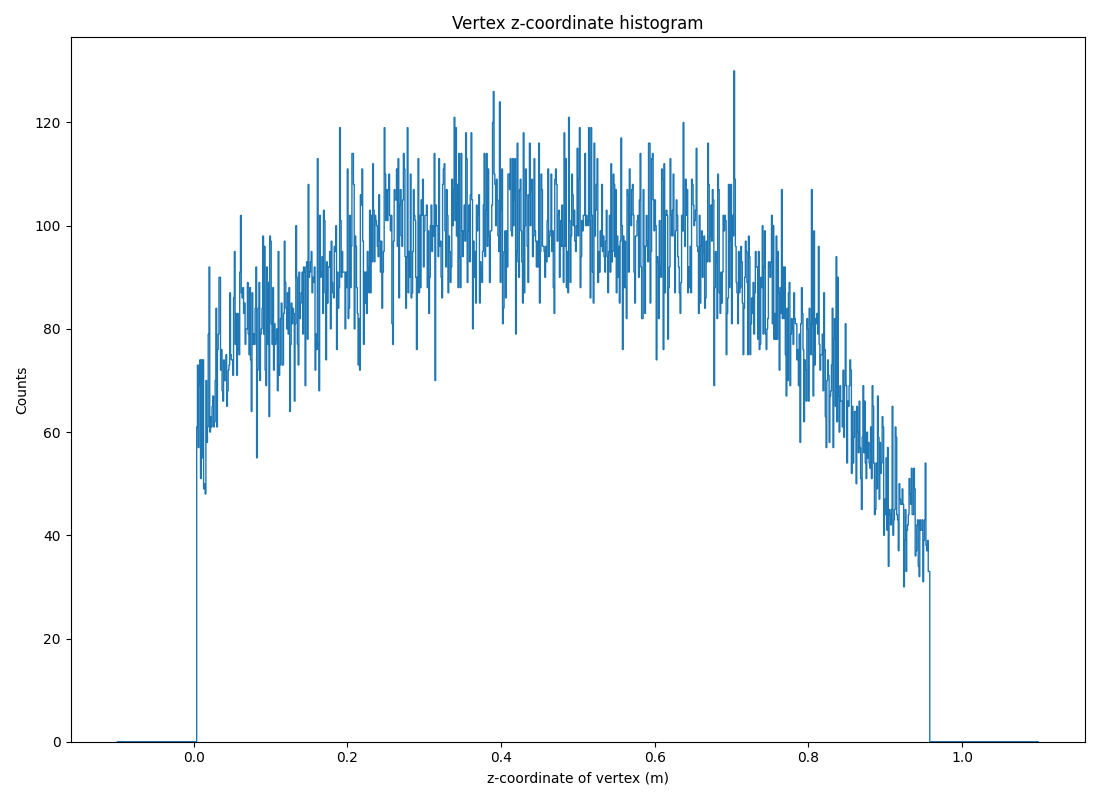

In [8]:
# Plot vertex z-ccordinate histogram
grammer.add_hist1d('z_vert', 1200, (-0.1, 1.1))
grammer.fill_hist1d('z_vert', results["z_vert"])
vertz = grammer.get_hist1d("z_vert")

fig, ax = plt.subplots(1,1)
ax.stairs(vertz.counts, edges=vertz.bins)
ax.set_title(f"Vertex z-coordinate histogram")
ax.set_xlabel("z-coordinate of vertex (m)")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

In [9]:
# Perform analysis of beam events
grammer.add_hist1d('beam_events_ic', 4095, (0.0, 4095.0))

bad_triggers = 0
total_triggers = 0
for run in range(run_min, run_max+1):
    df = None
    try:
        path = beam_events_path / f"{form_run_string(run)}.parquet"
        df = pl.read_parquet(path)
    except Exception:
        continue

    # # Code for finding beam events where no IC peak was found
    # df = df.filter(pl.col("ic_amplitude").list.len() == 0)
    # print(df.shape)
    
    # ic_amp = df.select(pl.col('ic_amplitude').list.explode()).null_count().item()
    # print(ic_amp)

    # ic_amp = df.filter((pl.col("ic_multiplicity") == 1.0)
    #             & (pl.col("ic_sca_multiplicity") == 1.0)
    #             & (abs(pl.col("ic_sca_multiplicity") - pl.col("ic_multiplicity")) <= 10))
    bad_triggers += df.select(pl.col('ic_amplitude').list.explode()).null_count().item()
    total_triggers += df.select(pl.len()).item()
    ic_amp = df.select(pl.col('ic_amplitude').list.get(0)).to_numpy().flatten()
    
    grammer.fill_hist1d('beam_events_ic', ic_amp)

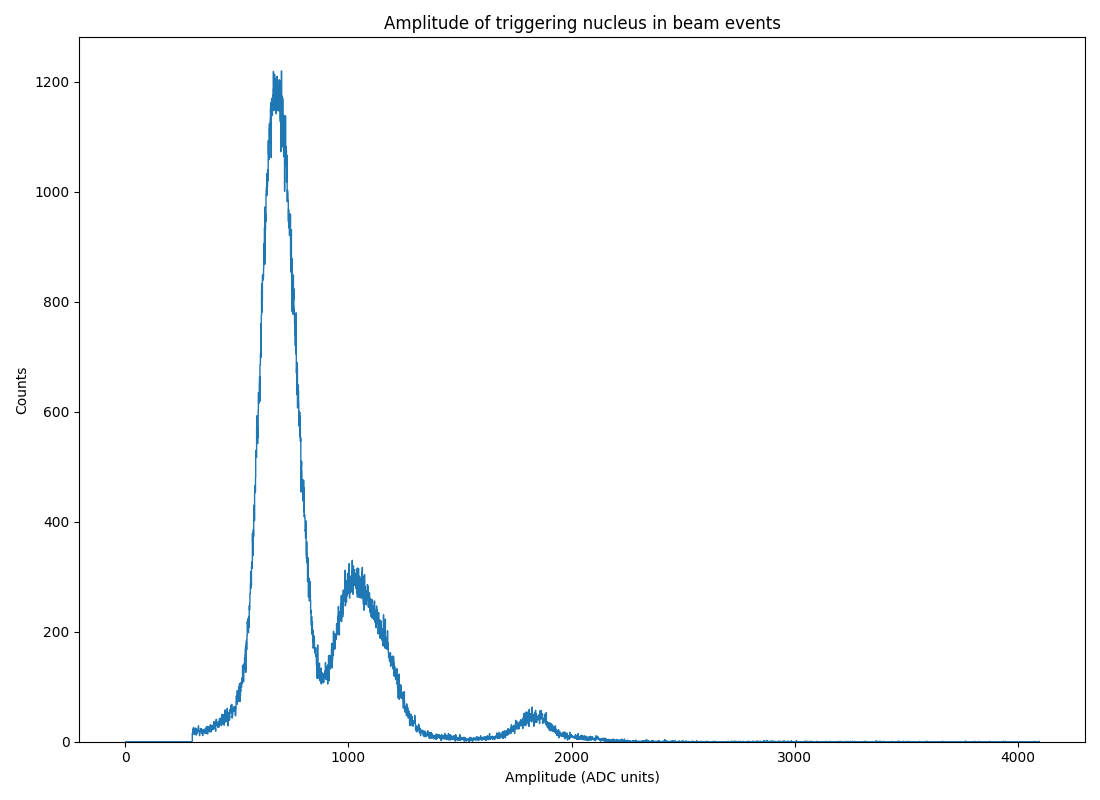

In [10]:
# Plot signal amplitude of beam particles in beam events
beam_events_ic = grammer.get_hist1d('beam_events_ic')

fig, ax = plt.subplots()
ax.stairs(beam_events_ic.counts, edges=beam_events_ic.bins)
ax.set_title('Amplitude of triggering nucleus in beam events')
ax.set_xlabel('Amplitude (ADC units)')
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

In [11]:
# Calculate kinematics for residual particle in given states
proj_energy_stop = proj_energy_start - target_material.get_energy_loss(projectile, proj_energy_start, np.array([1.0]))[0] # Energy at far end of detector
print(f"Beam energy range: {proj_energy_start}-{proj_energy_stop} MeV")
residual_excitations = np.array([0.0, 1.78])

# Do the calculation in the center of mass
cm_angle_range = np.linspace(0., np.pi, 1000)
# Calculate envelope from range of beam energies
eject_kinematics = np.zeros((len(residual_excitations), len(cm_angle_range) * 2, 2))

# Upper limit (maximum beam energy)
beam_vec_max = vector.array({
    "px": [0.0],
    "py": [0.0],
    "pz": [np.sqrt(proj_energy_start * (proj_energy_start + 2.0 * projectile.mass))],
    "E": [proj_energy_start + projectile.mass]
})
parent_max = target_vector + beam_vec_max
parent_cm_max = parent_max.boostCM_of(parent_max)
for idx, ex in enumerate(residual_excitations):
    eject_e_cm_max = (ejectile.mass**2.0 - (residual.mass + ex)**2.0 + parent_cm_max.E**2.0) / (2.0 * parent_cm_max.E)
    eject_p_cm_max = np.sqrt(eject_e_cm_max**2.0 - ejectile.mass**2.0)
    eject_vec_cms_max = vector.array({
        "px": eject_p_cm_max * np.sin(cm_angle_range),
        "py": np.zeros(len(cm_angle_range)),
        "pz": eject_p_cm_max * np.cos(cm_angle_range),
        "E": np.full(len(cm_angle_range), eject_e_cm_max)
    })
    eject_vec_lab_max = eject_vec_cms_max.boost(parent_max)
    eject_kinematics[idx, :len(cm_angle_range), 0] = eject_vec_lab_max.theta
    eject_kinematics[idx, :len(cm_angle_range), 1] = eject_vec_lab_max.E - ejectile.mass

# Lower limit (minimum beam energy)
beam_vec_min = vector.array({
    "px": [0.0],
    "py": [0.0],
    "pz": [np.sqrt(proj_energy_stop * (proj_energy_stop + 2.0 * projectile.mass))],
    "E": [proj_energy_stop + projectile.mass]
})
parent_min = target_vector + beam_vec_min
parent_cm_min = parent_min.boostCM_of(parent_min)
for idx, ex in enumerate(residual_excitations):
    eject_e_cm_min = (ejectile.mass**2.0 - (residual.mass + ex)**2.0 + parent_cm_min.E**2.0) / (2.0 * parent_cm_min.E)
    eject_p_cm_min = np.sqrt(eject_e_cm_min**2.0 - ejectile.mass**2.0)
    eject_vec_cms_min = vector.array({
        "px": eject_p_cm_min * np.sin(cm_angle_range),
        "py": np.zeros(len(cm_angle_range)),
        "pz": eject_p_cm_min * np.cos(cm_angle_range),
        "E": np.full(len(cm_angle_range), eject_e_cm_min)
    })
    eject_vec_lab_min = eject_vec_cms_min.boost(parent_min)
    # Note that lower limit is "flipped". We plot the band as a polygon, so need to continue from large lab angles to small lab angles
    eject_kinematics[idx, len(cm_angle_range):, 0] = np.flip(eject_vec_lab_min.theta)
    eject_kinematics[idx, len(cm_angle_range):, 1] = np.flip(eject_vec_lab_min.E - ejectile.mass)

Beam energy range: 93.0-80.68084236544945 MeV


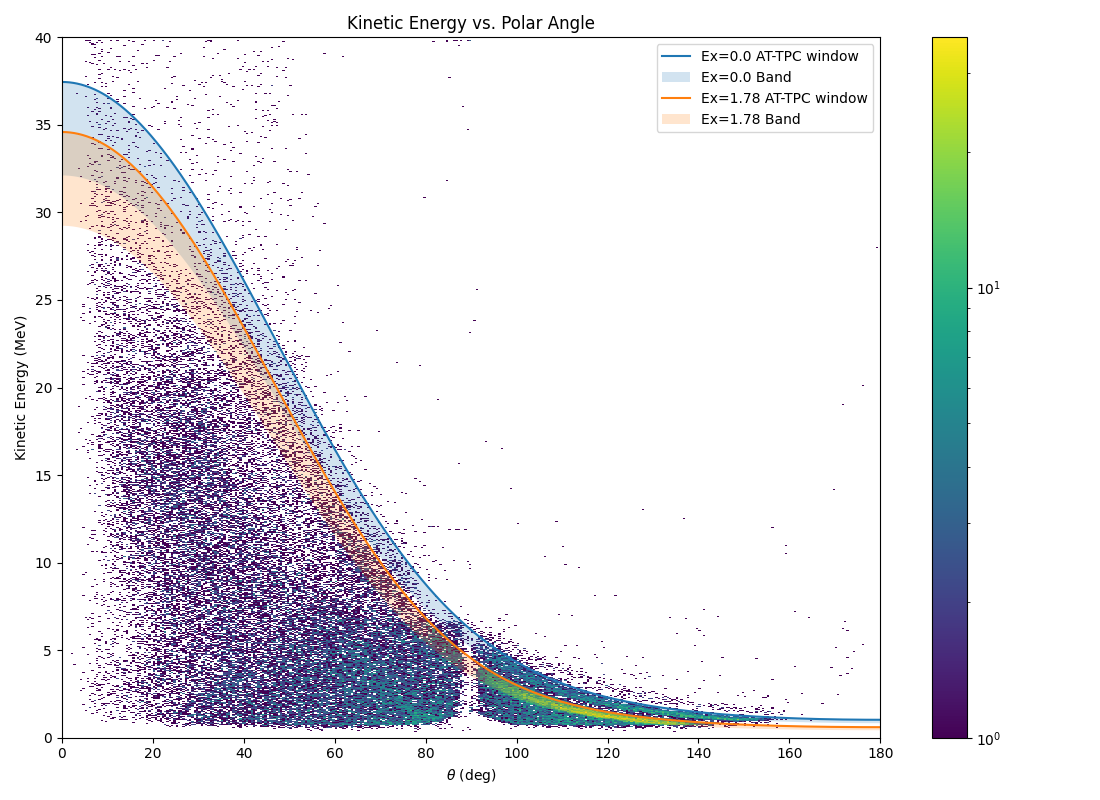

In [12]:
# Plot kinematics from data and compare with theoretical kinematics
grammer.add_hist2d('ke_theta', (360, 800), ((0.0, 180.0), (0.0, 40.0)))
grammer.fill_hist2d('ke_theta', np.rad2deg(results["polar"]), results["kinetic_energy"])
ke_theta = grammer.get_hist2d("ke_theta")

fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(ke_theta.x_bins, ke_theta.y_bins, ke_theta.counts, norm="log")
ax.set_title("Kinetic Energy vs. Polar Angle")
ax.set_xlabel(r"$\theta$ (deg)")
ax.set_ylabel("Kinetic Energy (MeV)")
fig.colorbar(mesh, ax=ax)
for idx, ex in enumerate(residual_excitations):
    ax.plot(np.rad2deg(eject_kinematics[idx, :len(cm_angle_range), 0]), eject_kinematics[idx, :len(cm_angle_range), 1], label=f"Ex={ex:02} AT-TPC window")
    # Fill idea thanks to D. Ramirez
    ax.fill(np.rad2deg(eject_kinematics[idx, :, 0]), eject_kinematics[idx, :, 1], label=f"Ex={ex:02} Band", alpha=0.2)
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
ax.legend()
fig.tight_layout()

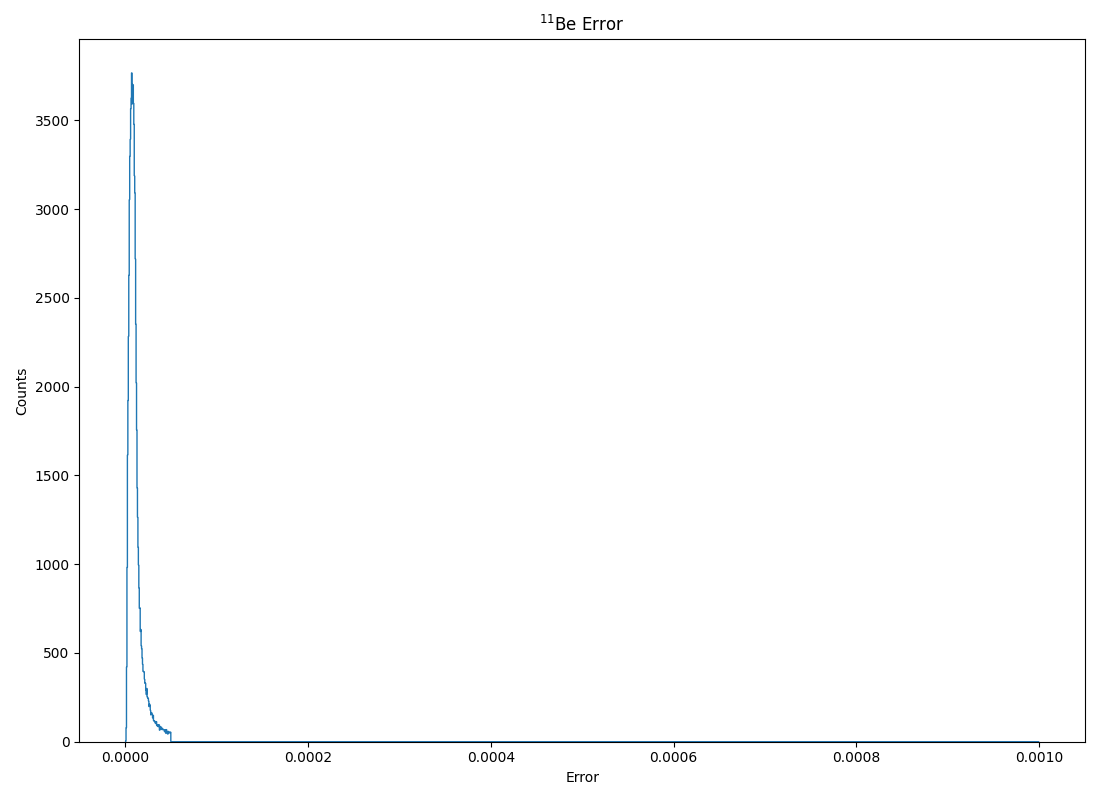

In [13]:
# Plot reduced chi-squared of fits to data
grammer.add_hist1d('chisq', 2000, (0.0, 1.0e-3))
grammer.fill_hist1d("chisq", results["chisq"])
hist = grammer.get_hist1d("chisq")

fig, ax = plt.subplots(1,1)
ax.stairs(hist.counts, edges=hist.bins)
ax.set_title(f"{residual.get_latex_rep()} Error")
ax.set_xlabel("Error")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

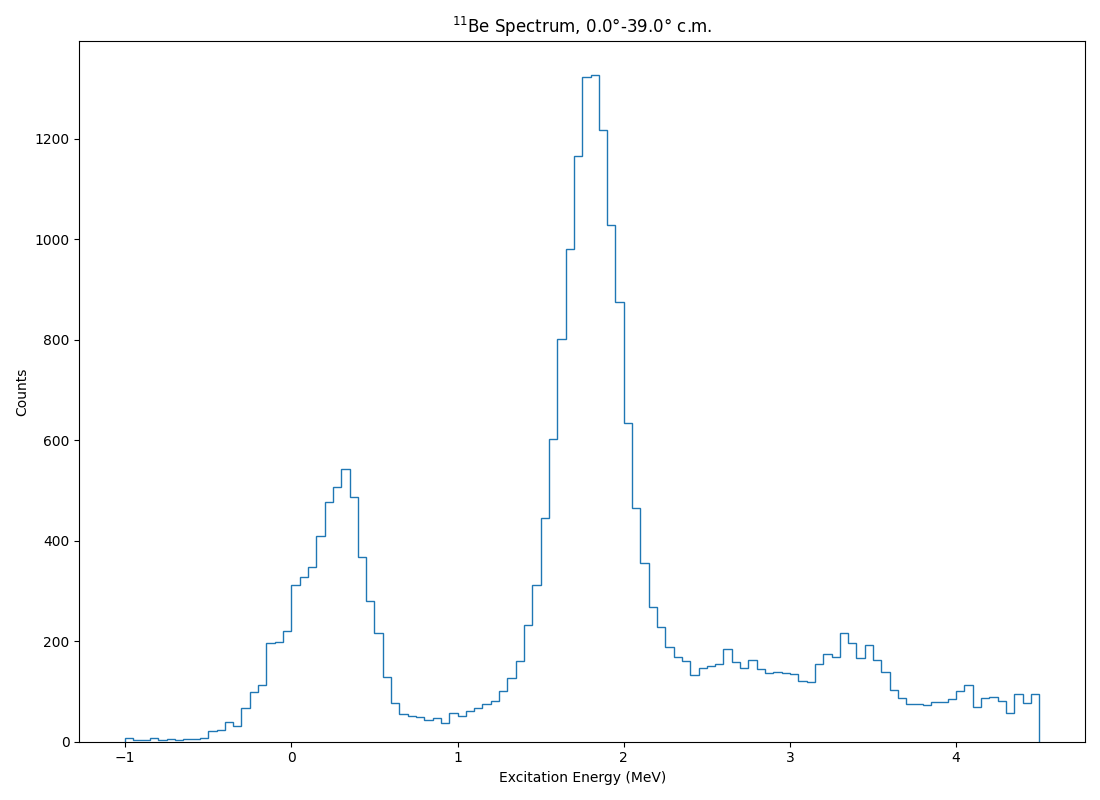

In [14]:
# Plot excitation energy spectrum

# Gate excitation spectrum on CM angle
mask_cm = (np.deg2rad(min_cm) <= results["cm_polar"]) & (results["cm_polar"] <= np.deg2rad(max_cm))    # Make note of asymmetric inequalites for binning!
ex_energy_gated = results["ex_energy"][mask_cm]

grammer.add_hist1d("ex_energy",ex_energy_bins, (ex_energy_min, ex_energy_max))
grammer.fill_hist1d("ex_energy", ex_energy_gated)

ex_hist = grammer.get_hist1d("ex_energy")
fig, ax = plt.subplots(1,1)
ax.stairs(ex_hist.counts, edges=ex_hist.bins)
ax.set_title(f"{residual.get_latex_rep()} Spectrum, {min_cm}\N{DEGREE SIGN}-{max_cm}\N{DEGREE SIGN} c.m.")
ax.set_xlabel("Excitation Energy (MeV)")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

In [15]:
# Make CM scattering angle histogram for input state

# Gate excitation spectrum on CM angle
mask_ex = (ex_en_min <= results["ex_energy"]) & (results["ex_energy"] < ex_en_max)    # Make note of asymmetric inequalites for binning!
cm_polar_gated = results["cm_polar"][mask_ex]

grammer.add_hist1d("cm_polar", ang_dist_bins, (min_cm, max_cm))
grammer.fill_hist1d("cm_polar", np.rad2deg(cm_polar_gated))

True

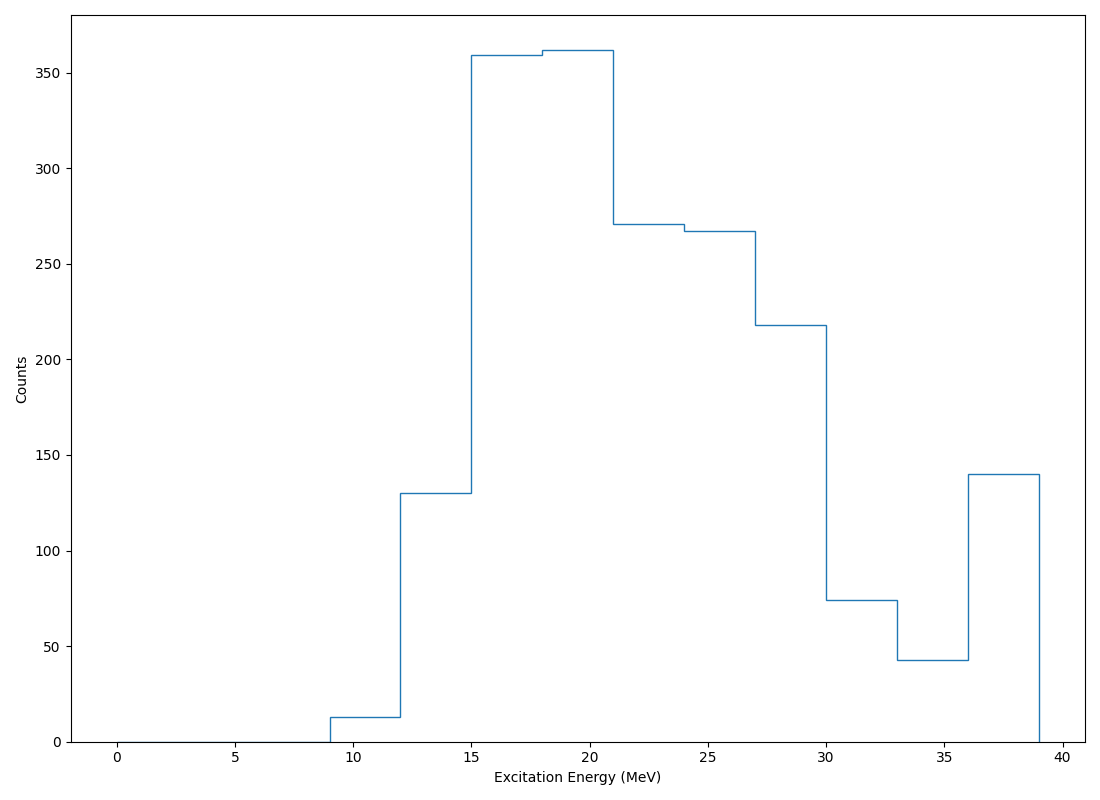

In [16]:
bruh = grammer.get_hist1d("cm_polar")
fig, ax = plt.subplots(1,1)
ax.stairs(bruh.counts, edges=bruh.bins)
ax.set_xlabel("Excitation Energy (MeV)")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

In [17]:
# Load background simulation config
run_min_sim = 1
run_max_sim = 14

bkgnd_sim_path = Path("/Volumes/e20009/dbu_sim/InterpSolver")        # Folder of simulated runs

In [18]:
# Create dictionary to store results from simulation
results_sim = {}

# Add keys for result parameters
results_sim["polar"] = np.empty(0, float)
results_sim["ex_energy"] = np.empty(0, float)
results_sim["cm_polar"] = np.empty(0, float)

In [19]:
# Analyze simulation runs
target_vector = vector.array({"px": [0.0], "py": [0.0], "pz": [0.0], "E": [target.mass]})
for run in range(run_min_sim, run_max_sim+1):
    df = None

    try:
        path = bkgnd_sim_path / f"run_{run:04d}_{ejectile.isotopic_symbol}.parquet"
        df = pl.read_parquet(path)
    except Exception:
        continue

    #Apply gates to data
    df = (df.filter((pl.col('redchisq') < redchi)
                   & (pl.col("vertex_z") >= min_z) 
                   & (pl.col("vertex_z") <= max_z)
                   )
            .sort("polar", descending=True)
            .unique("event", keep="first")
    )

    # Construct the projectile vectors (beam)
    vertices = df.select(['vertex_x', 'vertex_y', 'vertex_z']).to_numpy()
    distances = np.linalg.norm(vertices, axis=1)
    projectile_ke = proj_energy_start - target_material.get_energy_loss(projectile, proj_energy_start, distances)
    projectile_vector = vector.array({
        "px": np.zeros(len(projectile_ke)),
        "py": np.zeros(len(projectile_ke)),
        "pz": np.sqrt(projectile_ke * (projectile_ke + 2.0 * projectile.mass)),
        "E": projectile_ke + projectile.mass
    })

    # Construct the ejectile vectors (detected)
    brho = df.select('brho').to_numpy().flatten()
    momentum = df.select('brho').to_numpy().flatten() * float(ejectile.Z) * QBRHO_2_P
    kinetic_energy = np.sqrt(momentum**2.0 + ejectile.mass**2.0) - ejectile.mass
    polar = df.select('polar').to_numpy().flatten()
    az = df.select('azimuthal').to_numpy().flatten()
    ejectile_vector = vector.array({
        "px": momentum * np.sin(polar) * np.cos(az),
        "py": momentum * np.sin(polar) * np.sin(az),
        "pz": momentum * np.cos(polar),
        "E": np.sqrt(momentum**2.0 + ejectile.mass**2.0)
    })

    # Do the kinematics
    residual_vector = target_vector + projectile_vector - ejectile_vector # type: ignore
    ex_energy = residual_vector.mass - residual.mass # Excitation energy is "extra" mass

    # Calculate CM scattering angle 
    cm_vec = ejectile_vector.boostCM_of(projectile_vector + target_vector)
    cm_polar = np.pi - cm_vec.theta

    # Fill histograms and arrays
    results_sim["polar"] = np.append(results_sim["polar"], polar)
    results_sim["ex_energy"] = np.append(results_sim["ex_energy"], ex_energy)
    results_sim["cm_polar"] = np.append(results_sim["cm_polar"], cm_polar)

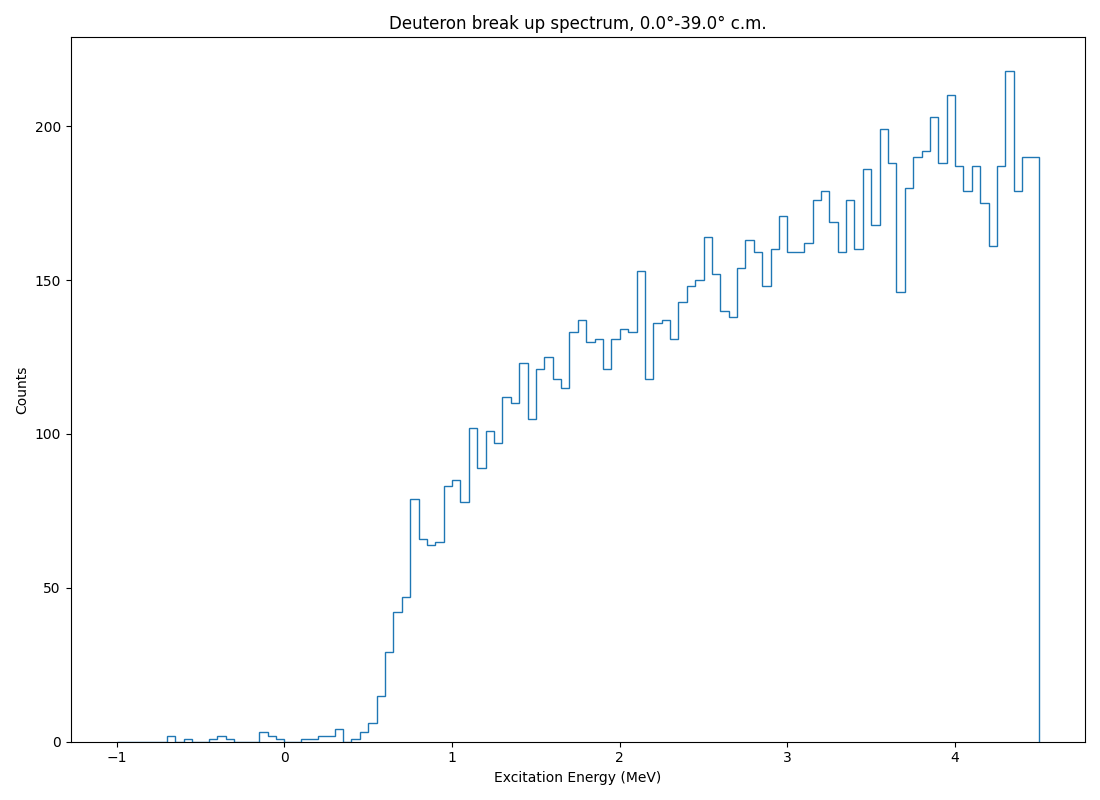

In [20]:
# Plot simulation excitation energy spectrum

# Gate excitation spectrum on CM angle
mask = (np.deg2rad(min_cm) <= results_sim["cm_polar"]) & (results_sim["cm_polar"] < np.deg2rad(max_cm))    # Make note of asymmetric inequalites for binning!
ex_energy_gated = results_sim["ex_energy"][mask]

grammer.add_hist1d("ex_energy_sim",ex_energy_bins, (ex_energy_min, ex_energy_max))
grammer.fill_hist1d("ex_energy_sim", ex_energy_gated)

ex_hist_sim = grammer.get_hist1d("ex_energy_sim")
fig, ax = plt.subplots(1,1)
ax.stairs(ex_hist_sim.counts, edges=ex_hist_sim.bins)
ax.set_title(f"Deuteron break up spectrum, {min_cm}\N{DEGREE SIGN}-{max_cm}\N{DEGREE SIGN} c.m.")
ax.set_xlabel("Excitation Energy (MeV)")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

In [21]:
# Characterize background in excitation spectrum

# Create dictionary to store results of excitation background removal
sub_fits = {}

# Create background shape function using simulation
bkgnd_hist = grammer.get_hist1d("ex_energy_sim")
bkgnd_bins = bkgnd_hist.bins[:-1] + bkgnd_hist.bin_width/2
bkgnd_counts = bkgnd_hist.counts

def bkgnd_shape(x, A):
    """
        
    """
    return A * bkgnd_counts

# Make array of edges of angular cuts
grammer.add_hist1d("ang_dist", ang_dist_bins, (min_cm, max_cm))
ang_bins = grammer.get_hist1d("ang_dist").bins

# Make array of excitation spectrum bins
total_bins = ex_hist.bins[:-1] + ex_hist.bin_width/2

for idx in range(len(ang_bins) - 1):
    low_edge = ang_bins[idx]
    high_edge = ang_bins[idx+1]

    # Gate excitation spectrum on CM angle
    mask = (np.deg2rad(low_edge) <= results["cm_polar"]) & (results["cm_polar"] < np.deg2rad(high_edge))    # Make note of asymmetric inequalites for binning!
    ex_energy_gated = results["ex_energy"][mask]

    # Make and fill histogram
    title = f"ex_energy_{low_edge}-{high_edge}"
    grammer.add_hist1d(title, ex_energy_bins, (ex_energy_min, ex_energy_max))
    grammer.fill_hist1d(title, ex_energy_gated)
    sub_ex_hist = grammer.get_hist1d(title)

    # Fit histogram
    peak1 = lmfit.models.VoigtModel(prefix="peak1_")
    peak1_bins, peak1_counts = sub_ex_hist.get_subrange((-0.5, 0.1))
    peak1_bins += 0.5 * sub_ex_hist.bin_width
    peak1_counts[peak1_counts == 0.0] = 1.0
    peak1_weights = 1.0/np.sqrt(peak1_counts)
    peak1_weights[peak1_counts == 0.0] = 1.0
    pars = peak1.guess(x=peak1_bins, data=peak1_counts, weights=peak1_weights)
    pars["peak1_amplitude"].min = 0.0

    peak2 = lmfit.models.VoigtModel(prefix="peak2_")
    peak2_bins, peak2_counts = sub_ex_hist.get_subrange((0.1, 0.7))
    peak2_bins += 0.5 * sub_ex_hist.bin_width
    peak2_weights = 1.0/np.sqrt(peak2_counts)
    peak2_weights[peak2_counts == 0.0] = 1.0
    pars.update(peak2.guess(x=peak2_bins, data=peak2_counts, weights=peak2_weights))
    pars["peak2_amplitude"].min = 0.0

    peak3 = lmfit.models.VoigtModel(prefix="peak3_")
    peak3_bins, peak3_counts = sub_ex_hist.get_subrange((1.3, 2.2))
    peak3_bins += 0.5 * sub_ex_hist.bin_width
    peak3_weights = 1.0/np.sqrt(peak3_counts)
    peak3_weights[peak3_counts == 0.0] = 1.0
    pars.update(peak3.guess(x=peak3_bins, data=peak3_counts, weights=peak3_weights))
    pars["peak3_amplitude"].min = 0.0

    peak4 = lmfit.models.VoigtModel(prefix="peak4_")
    peak4_bins, peak4_counts = sub_ex_hist.get_subrange((2.4, 2.9))
    peak4_bins += 0.5 * sub_ex_hist.bin_width
    peak4_weights = 1.0/np.sqrt(peak4_counts)
    peak4_weights[peak4_counts == 0.0] = 1.0
    pars.update(peak4.guess(x=peak4_bins, data=peak4_counts, weights=peak4_weights))
    pars["peak4_amplitude"].min = 0.0

    peak5 = lmfit.models.VoigtModel(prefix="peak5_")
    peak5_bins, peak5_counts = sub_ex_hist.get_subrange((3.1, 3.6))
    peak5_bins += 0.5 * sub_ex_hist.bin_width
    peak5_weights = 1.0/np.sqrt(peak5_counts)
    peak5_weights[peak5_counts == 0.0] = 1.0
    pars.update(peak5.guess(x=peak5_bins, data=peak5_counts, weights=peak5_weights))
    pars["peak5_amplitude"].min = 0.0

    # bkgnd = lmfit.models.LinearModel(prefix="bkgnd_")
    # bkgnd_bins, bkgnd_counts = ex_hist.get_subrange((-1.0, 4.0))
    # bkgnd_bins += 0.5 * ex_hist.bin_width
    # bkgnd_weights = 1.0/np.sqrt(bkgnd_counts)
    # bkgnd_weights[bkgnd_counts == 0.0] = 1.0
    # pars.update(bkgnd.guess(x=bkgnd_bins, data=bkgnd_counts))
    # pars["bkgnd_slope"].min = 0.0

    # bkgnd_script="""
    # def square_root(x, A, cen, pwr, off):
    #     value = A * ((x - cen) ** pwr) + off
    #     return value
    # """

    # custom = lmfit.models.ExpressionModel("square_root(x, A, cen, pwr, off)", independent_vars=['x'],
    #                                       init_script=bkgnd_script)
    # pars.update(custom.make_params(A=1, cen=0.5, pwr=0.5, off=0))
    # pars["A"].min = 0.0
    # pars["off"].min = 0.0
    # pars["cen"].exp = "cen <= x"
    # pars["pwr"].vary = False

    bkgnd = lmfit.Model(bkgnd_shape, prefix="bkgnd_")
    pars.update(bkgnd.make_params(A=1))
    pars["bkgnd_A"].min = 0.0

    total_fit = peak1 + peak2 + peak3 + peak4 + peak5 + bkgnd
    total_bins = sub_ex_hist.bins[:-1] + sub_ex_hist.bin_width/2
    total_counts = sub_ex_hist.counts
    total_counts[total_counts == 0.0] = 1.0
    total_weights = 1.0/np.sqrt(total_counts)
    total_weights[total_counts == 0.0] = 1.0
    total_result = total_fit.fit(params=pars, x=total_bins, data=total_counts, weights=total_weights)

    # Store total fit result
    sub_fits[title] = total_result

/var/folders/bw/y4pzq3gd7xz5153vnxz2rn7w0000gq/T/ipykernel_59390/3204386023.py:51: RuntimeWarning: divide by zero encountered in divide
  peak2_weights = 1.0/np.sqrt(peak2_counts)
/var/folders/bw/y4pzq3gd7xz5153vnxz2rn7w0000gq/T/ipykernel_59390/3204386023.py:59: RuntimeWarning: divide by zero encountered in divide
  peak3_weights = 1.0/np.sqrt(peak3_counts)
/var/folders/bw/y4pzq3gd7xz5153vnxz2rn7w0000gq/T/ipykernel_59390/3204386023.py:67: RuntimeWarning: divide by zero encountered in divide
  peak4_weights = 1.0/np.sqrt(peak4_counts)
/var/folders/bw/y4pzq3gd7xz5153vnxz2rn7w0000gq/T/ipykernel_59390/3204386023.py:75: RuntimeWarning: divide by zero encountered in divide
  peak5_weights = 1.0/np.sqrt(peak5_counts)


In [22]:
idx=-1

<Parameter 'bkgnd_A', value=0.9999999999999998, bounds=[0.0:inf]>


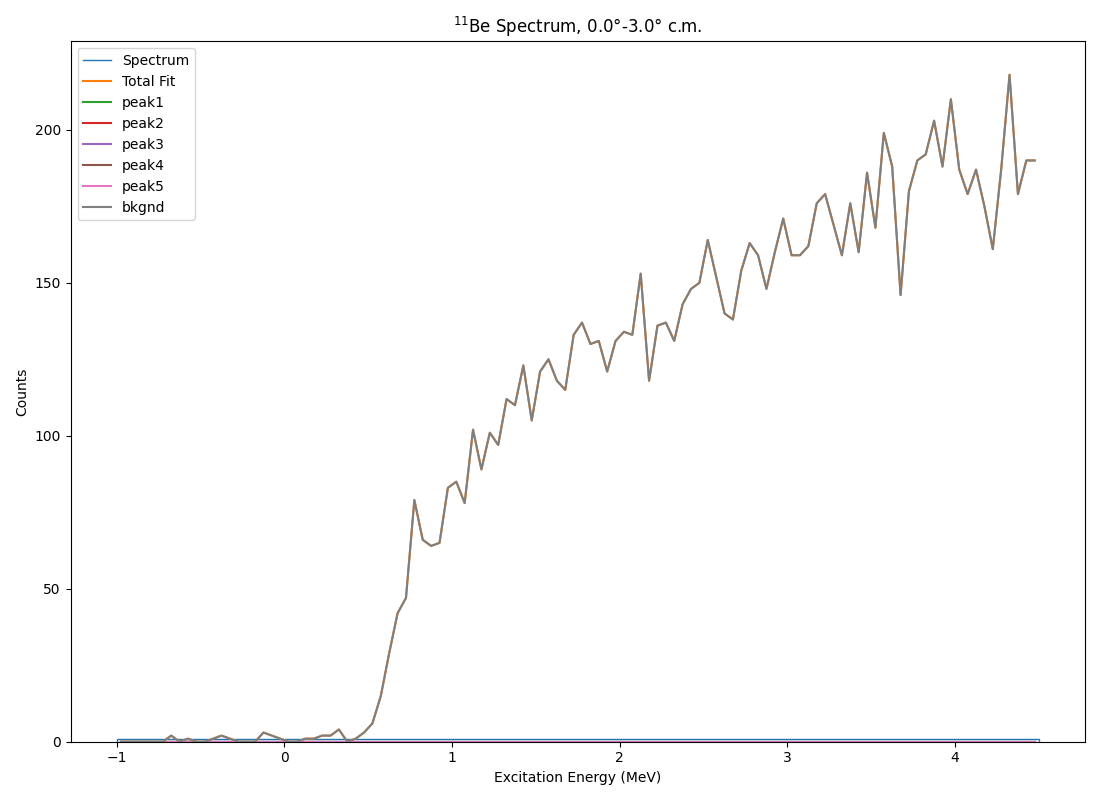

In [23]:
# Check results of the fits
idx += 1

low_edge = ang_bins[idx]
high_edge = ang_bins[idx+1]

title = f"ex_energy_{low_edge}-{high_edge}"

# Get results of fit
sub_fit_result = sub_fits[title]
comps = sub_fit_result.eval_components()
print(sub_fit_result.params['bkgnd_A'])

# Plot result
fig, ax = plt.subplots(1,1)
sub_ex_hist = grammer.get_hist1d(title)
ax.stairs(sub_ex_hist.counts, edges=sub_ex_hist.bins, label="Spectrum")
ax.plot(total_bins, sub_fit_result.best_fit, label="Total Fit")
ax.plot(total_bins, comps["peak1_"], label="peak1")
ax.plot(total_bins, comps["peak2_"], label="peak2")
ax.plot(total_bins, comps["peak3_"], label="peak3")
ax.plot(total_bins, comps["peak4_"], label="peak4")
ax.plot(total_bins, comps["peak5_"], label="peak5")
ax.plot(total_bins, comps["bkgnd_"], label="bkgnd")
ax.set_title(f"{residual.get_latex_rep()} Spectrum, {low_edge}\N{DEGREE SIGN}-{high_edge}\N{DEGREE SIGN} c.m.")
ax.set_xlabel("Excitation Energy (MeV)")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
ax.legend()
fig.tight_layout()

In [24]:
# Subtract background from excitation spectrum and CM scattering angle histogram

grammer.add_hist1d("ex_energy_bkgnd_rm", ex_energy_bins, (ex_energy_min, ex_energy_max))
ex_hist_bkgnd_rm = grammer.get_hist1d("ex_energy_bkgnd_rm")
ex_counts = ex_hist_bkgnd_rm.counts.copy()

for title, fit in sub_fits.items():
    sub_ex_hist = grammer.get_hist1d(title)
    strength = fit.params["bkgnd_A"]
    sub_ex_hist_counts = sub_ex_hist.counts - bkgnd_shape(_, strength)

    # MAY BE BAD, NOT ALLOWING NEGATIVE COUNTS
    neg_mask = sub_ex_hist_counts < 0
    sub_ex_hist_counts[neg_mask] = 0

    ex_counts = ex_counts + sub_ex_hist_counts

ex_hist_bkgnd_rm.counts = ex_counts

In [34]:
# Subtract background from CM scattering angle histogram
grammer.add_hist1d("cm_polar_bkgnd_rm", ang_dist_bins, (min_cm, max_cm))

cm_hist = grammer.get_hist1d("cm_polar")
cm_counts = cm_hist.counts.copy()
print(cm_counts)
for bin, fit in zip(cm_counts, sub_fits.items()):
    strength = fit[1].params["bkgnd_A"]
    bin *= (1 - strength)
    print(bin)
print(cm_counts)
cm_hist_bkgnd_rm = grammer.get_hist1d("cm_polar_bkgnd_rm")
cm_hist_bkgnd_rm.counts = cm_counts




Overwriting histogram named cm_polar_bkgnd_rm in Histogrammer.add_histogram!
[  0   0   0  13 130 359 362 271 267 218  74  43 140]
0.0
0.0
0.0
12.965022471875809
129.99999999998857
354.6231128417749
345.89645007554896
264.5441835563333
262.3391158425301
217.43369354849253
73.49691387365147
42.39029705023841
139.99999999989708
[  0   0   0  13 130 359 362 271 267 218  74  43 140]


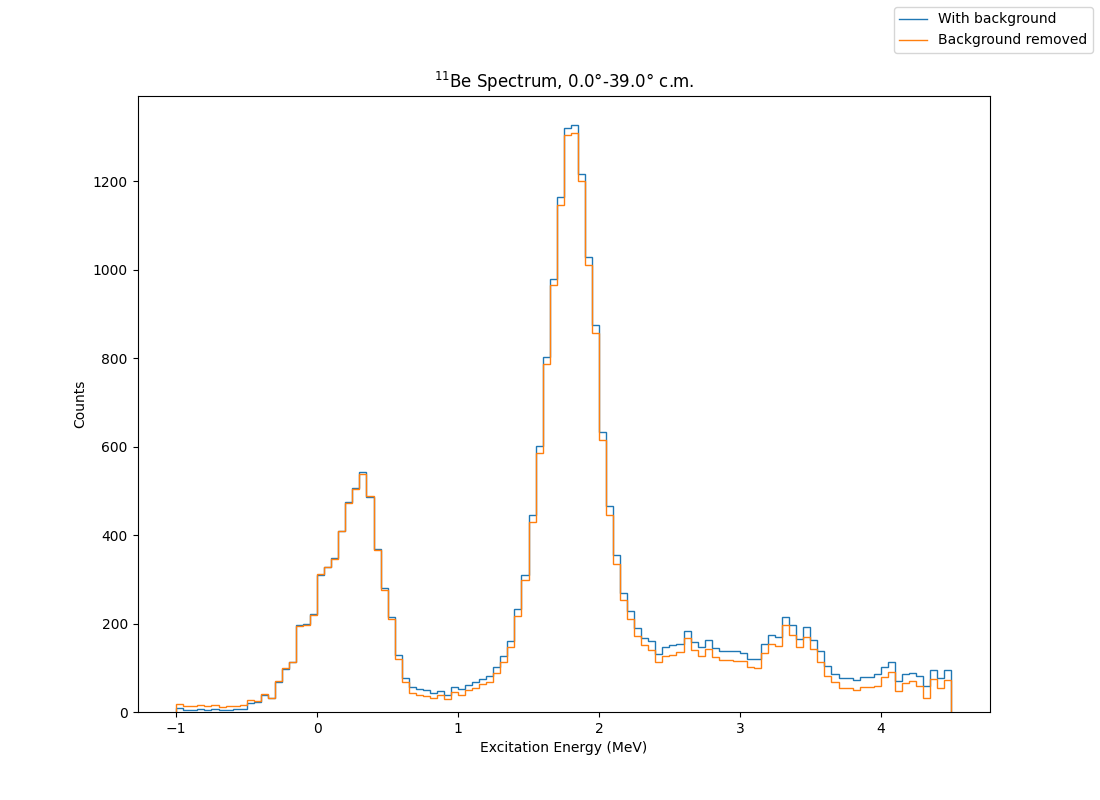

In [26]:
# Plot residual excitation energy spectrum
fig, ax = plt.subplots(1,1)
ax.stairs(ex_hist.counts, edges=ex_hist.bins, label="With background")
ax.stairs(ex_hist_bkgnd_rm.counts, edges=ex_hist_bkgnd_rm.bins, label="Background removed")
ax.set_title(f"{residual.get_latex_rep()} Spectrum, {min_cm}\N{DEGREE SIGN}-{max_cm}\N{DEGREE SIGN} c.m.")
ax.set_xlabel("Excitation Energy (MeV)")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.legend()
# fig.tight_layout()

In [27]:
# Calculate cross section
beam_rate, _, _ = beam_events_ic.stats_for_range((ic_min_val, ic_max_val))
beam_rate *= downscale_factor # Units of counts / time

length = max_z - min_z    # Units of meters
nuclei_areal_density = pressure * torr_2_pascal * length / boltzmann / temperature * stoich * 1.0e-31 # Units of target nuclei / millibarns

cm_hist = grammer.get_hist1d("cm_polar")
bins = cm_hist.bins
bin_width = cm_hist.bin_width

xs = cm_hist.counts / np.sin(np.deg2rad(bins[:len(bins)-1]+bin_width/2)) / np.deg2rad(bin_width) / (2 * np.pi * beam_rate * nuclei_areal_density)   # Units of millibarns / steradians
err = np.sqrt(cm_hist.counts) / np.sin(np.deg2rad(bins[:len(bins)-1]+bin_width/2)) / np.deg2rad(bin_width) / (2 * np.pi * beam_rate * nuclei_areal_density)

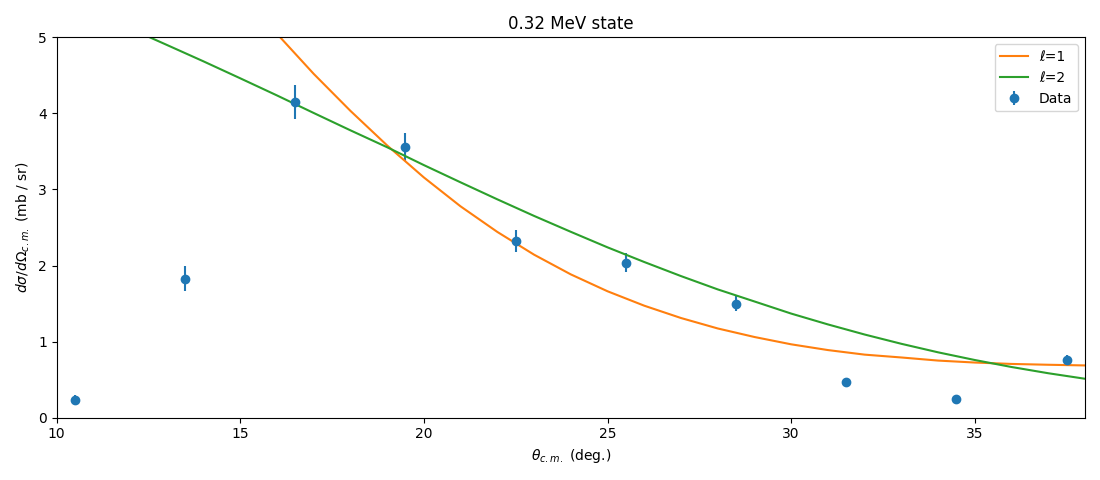

In [28]:
# Plot angular distribution
# arb_xs = cm_hist.counts / np.sin(np.deg2rad(bins[:len(bins)-1]+bin_width/2)) / bin_width
# err = np.sqrt(cm_hist.counts) / np.sin(np.deg2rad(bins[:len(bins)-1]+bin_width/2)) / bin_width

# Ptolemy DWBA calculations
es3_l1 = pl.read_csv("/Volumes/e20009/ptolemy/11Be/3.4_mev/l1/beam_93mev.csv")
es3_l1_93 = es3_l1.to_dict(as_series=True)
es3_l2 = pl.read_csv("/Volumes/e20009/ptolemy/11Be/3.4_mev/l2/beam_93mev.csv")
es3_l2_93 = es3_l2.to_dict(as_series=True)
es2_l2 = pl.read_csv("/Volumes/e20009/ptolemy/11Be/1.78_mev/l2/beam_93mev.csv")
es2_l2_93 = es2_l2.to_dict(as_series=True)
es2_l1 = pl.read_csv("/Volumes/e20009/ptolemy/11Be/1.78_mev/l1/beam_93mev.csv")
es2_l1_93 = es2_l1.to_dict(as_series=True)

fig, ax = plt.subplots(1,1)
ax.errorbar(bins[:len(bins)-1]+bin_width/2, xs, yerr=err, fmt='o', label="Data")

ax.plot(es3_l1_93['cm_angle'],es3_l1_93['xs_mb']*0.15, label="ℓ=1")
ax.plot(es3_l2_93['cm_angle'],es3_l2_93['xs_mb']*0.08, label="ℓ=2")
# ax.plot(es2_l2_93['cm_angle'],es2_l2_93['xs_mb']*.29, label="ℓ=2")
# ax.plot(es2_l1_93['cm_angle'],es2_l1_93['xs_mb']*0.7, label="ℓ=1")

ax.set_title(f"{residual.get_latex_rep()} CM Scattering Angle")
ax.set_title("0.32 MeV state")
ax.set_xlabel(r"$\theta_{c.m.}$ (deg.)")
ax.set_ylabel(r"$d\sigma / d\Omega_{c.m.}$ (mb / sr)")
ax.legend()
plt.xlim(10,38)
plt.ylim(0,5)
fig.set_figwidth(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

In [29]:
# Plot angular distribution
cm_sim = grammer.get_hist1d("cm_polar_sim_bkgnd")
bin_width = cm_sim.bin_width
bins=cm_sim.bins
arb_xs = cm_sim.counts / np.sin(np.deg2rad(bins[:len(bins)-1]+bin_width/2)) / bin_width
err = np.sqrt(cm_hist.counts) / np.sin(np.deg2rad(bins[:len(bins)-1]+bin_width/2)) / bin_width

fig, ax = plt.subplots(1,1)
ax.errorbar(bins[:len(bins)-1]+bin_width/2, arb_xs, yerr=err, fmt='o', label="Data")

ax.set_title(f"{residual.get_latex_rep()} CM Scattering Angle")
ax.set_title("0.32 MeV state")
ax.set_xlabel(r"$\theta_{c.m.}$ (deg.)")
ax.set_ylabel(r"$d\sigma / d\Omega_{c.m.}$ (mb / sr)")
ax.legend()
plt.xlim(0,38)
# plt.ylim(0,5)
fig.set_figwidth(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

AttributeError: 'NoneType' object has no attribute 'bin_width'